In [ ]:
####
### Before running the code, the path of the files need to change for the whole code to work. 
###

##os.chdir('C:\\Users\\Tan Vo\\Documents\\test\\Weather_CSV')
##parquet_path = 'C:\\Users\\Tan Vo\\Documents\\test\\Weather_Parquet\\'
## See below and change path in the sub-window [9]

In [1]:
#The test was ran on my local machine using Jupter Notebook. 
#The process in running the data has reached 100% CPU and memory =/ 
#Memory has imrpoved when I disabed window defender and other small files. 

#My Laptop System
#Ram 4gb
#Processor Intel core(TM) M3 

In [2]:
#Questions

#In the monthly file 20160201:
#Which date was the hottest day? 2016-02-21
#What was the temperature on that day? 15.6 Celsius
#In which region was the hottest day? South West England

#In the monthly file 20160301:   
#Which date was the hottest day? 2016-03-17
#What was the temperature on that day? 15.8 Celsius
#In which region was the hottest day? Highland & Eilean Siar

In [3]:
##### Note
# SiteName Great Dun Fell and Orlock contain high proportion of missing temperature, however this has not been removed in this exercise.
# Some SiteName contains missing dates and hours. I tried to fill in the missing dates and hours, but the execution for the tables to join took too long. 
# Missing values in temperature can be replace by previous values using the fillna method. Assume the continue daily pattern. 
#Expect high likelihood of weather in the current day can be used to predict the next day to fill missing value. 
# Windgust has been dropped given that it contains 70% missing value. 
# The region 'Strathclyde' was classify as England. This was replace to Scotland. A list has been created to categories this later in the code. Assume this is fixed.  

#Similar assumption to missing values in visibility, pressure, SignificantWeatherCode. This could be fill with missing value from previous value. 
#Extreme weather conditions are unlikely scenario and is an outlier. Using previous values to fill in missing value is sensible, but could be improve further to improve accuracy. 

#Created dummmy variable 'count'. It contain value 1. This is used to partition by count to collect information on hottest day. 

In [4]:
####
### I have created 4 sections. 
### Section 1 is the main work to answer the questions for the test
### Section 2 is to build a new table to fill missing dates for each SiteName and to fill missing values for other variables. 
### However, I stop halfway because the exeuction took too long. 
### Section 3 is extra work building a line graph for maximum temp by Region. 
### Section 4 is extra work building scatter plots. 

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import os
import glob
import pandas as pd
#import numpy as np 

from datetime import datetime

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import Window

from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
#Version
spark = SparkSession.builder \
          .master("local") \
          .config("spark.sql.repl.eagerEval.enabled", True) \
          .getOrCreate()
print('Spark Version: ' +spark.version) #3.0.0
import sys
print(sys.version) #3.7.6

Spark Version: 3.0.0
3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [8]:
####
###Section 1
####

In [9]:
##########
#Uploading Csv files to parquet 
##########

#####
#Path
####
os.chdir('C:\\Users\\Tan Vo\\Documents\\test\\Weather_CSV')
parquet_path = 'C:\\Users\\Tan Vo\\Documents\\test\\Weather_Parquet\\'

#Drop Columns - Not needed for analysis 
cols_to_drop = ['ForecastSiteCode','Latitude','Longitude']


#Parquet Dataframe
df = {}
df_date = []
for f in os.listdir():
    #Read CSV file
    weather_data = pd.read_csv(f, header = 0)
    #print(f)
    #weather_data.info()
    #print('\n')
    #Extract the file names and extentions 
    file_name, file_ext = os.path.splitext(f)
    #Extract dates of the file
    weather, f_date = file_name.split('.')
    #date_time_obj = datetime.strptime(f_date, '%Y%m%d') 
    
    #append dates 
    df_date.append(f_date)
    
    weather_data.to_parquet(parquet_path + '{}.parquet'.format(file_name))
    df[f_date] = spark.read.parquet(parquet_path +file_name +'.parquet' )
    df[f_date] = df[f_date].drop(*cols_to_drop)
    df[f_date] = df[f_date].orderBy('SiteName','ObservationDate','ObservationTime')
    count = df[f_date].count()
    print(file_name + file_ext  + ' ' + 'is store in df[' + f_date + ']' + '.' + ' This data contains' + ' ' + str(count)\
         + ' rows.')     
    df[f_date].printSchema()
    
    

weather.20160201.csv is store in df[20160201]. This data contains 93255 rows.
root
 |-- ObservationTime: long (nullable = true)
 |-- ObservationDate: string (nullable = true)
 |-- WindDirection: long (nullable = true)
 |-- WindSpeed: long (nullable = true)
 |-- WindGust: double (nullable = true)
 |-- Visibility: double (nullable = true)
 |-- ScreenTemperature: double (nullable = true)
 |-- Pressure: double (nullable = true)
 |-- SignificantWeatherCode: long (nullable = true)
 |-- SiteName: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Country: string (nullable = true)

weather.20160301.csv is store in df[20160301]. This data contains 101442 rows.
root
 |-- ObservationTime: long (nullable = true)
 |-- ObservationDate: string (nullable = true)
 |-- WindDirection: long (nullable = true)
 |-- WindSpeed: long (nullable = true)
 |-- WindGust: double (nullable = true)
 |-- Visibility: double (nullable = true)
 |-- ScreenTemperature: double (nullable = true)
 |-- Pressure

In [10]:
####
##Drop Duplciates 
###

for x in df:
    count = df[x].count()
    print(x + " - " + str(count) + " rows" + "\n")
    df[x] = df[x].dropDuplicates()
    count_drop = df[x].count()
    if count != count_drop: 
        print(x + " - " + str(count_drop) + " rows after removing duplicates ")
    

20160201 - 93255 rows

20160301 - 101442 rows

20160301 - 101304 rows after removing duplicates 


In [11]:
######
###Add Datetime
#### 
#for x in df:
#    df[x] = df[x].withColumn("ObservationTime",lpad('ObservationTime', 2, '0'))\
#            .withColumn('ObservationDate', to_timestamp('ObservationDate'))\
#            .withColumn('ObservationTimestamp', from_unixtime(unix_timestamp('ObservationDate') + unix_timestamp('ObservationTime', 'HH')))
#    print(x + ' - ObservationTime format change to HH')

for x in df:
    #df[x] = df[x].withColumn('ObservationDate', to_timestamp('ObservationDate')).withColumn('Count', lit(1))
    df[x] = df[x].withColumn('ObservationDate', to_date('ObservationDate')).withColumn('Count', lit(1))

In [12]:
#####
##Dropping Data
######

def column_dropper(x, threshold):
    # Takes a dataframe and threshold for missing values. Returns a dataframe. 
    total_records = df[x].count()
    for col in df[x].columns:
        #Calculate the percentage of missing values
        missing = df[x].where(df[x][col].isNull()).count()
        missing_percent = int(missing / total_records * 100)
        if missing_percent > 0:
            print(str(x) + ' - ' + col + ':' + ' ' + str(missing_percent) + '% contains missing values.' )
        # Drop column if percent of missing is more than threshold 
        if missing_percent > threshold:           
            df[x] = df[x].drop(col)
            print(str(x) + ' - ' + col + ' has been drop')
    print("\n")
        
    
for x in df:
    column_dropper(x, 60)
    


20160201 - WindGust: 70% contains missing values.
20160201 - WindGust has been drop
20160201 - Visibility: 13% contains missing values.
20160201 - Pressure: 7% contains missing values.
20160201 - Country: 14% contains missing values.


20160301 - WindGust: 84% contains missing values.
20160301 - WindGust has been drop
20160301 - Visibility: 13% contains missing values.
20160301 - Pressure: 8% contains missing values.
20160301 - Country: 14% contains missing values.




In [13]:
###
### Fill Country Missing Values
### 
England = ['East Midlands','East of England','London & South East England','North East England','North West England',
          'South West England', 'West Midlands', 'Yorkshire & Humber']

Scotland = ['Central Tayside & Fife','Dumfries, Galloway','Grampian','Highland & Eilean Siar','Orkney & Shetland',
            'Strathclyde']

Ireland = ['Northern Ireland']

Wales = ['Wales']

for x in df: 
    df[x] = df[x].withColumn('Country', when(col('Region').isin(England), 'ENGLAND')\
                             .when(col('Region').isin(Scotland), 'SCOTLAND')\
                             .when(col('Region').isin(Ireland), 'NORTHERN IRELAND')\
                             .when(col('Region').isin(Wales), 'WALES')
                             .otherwise('Other'))
    
    #Function 
    column_dropper(x,60)
    #print(x)
    #df[x].select(['Region', 'Country']).groupBy('Region','Country').count().show(truncate=100)

    

20160201 - Visibility: 13% contains missing values.
20160201 - Pressure: 7% contains missing values.


20160301 - Visibility: 13% contains missing values.
20160301 - Pressure: 8% contains missing values.




In [14]:
for x in df:
    Count_Temp = df[x].select('ScreenTemperature').filter('ScreenTemperature = -99').count()
    df[x] = df[x].withColumn('ScreenTemperature', when(col('ScreenTemperature') == -99, None).otherwise(col('ScreenTemperature')))
    print(x + " - ScreenTemperature has value -99 " + str(Count_Temp) + " rows, this has been updated to None ")
    Count_Code = df[x].select('SignificantWeatherCode').filter('SignificantWeatherCode = -99').count()
    df[x] = df[x].withColumn('SignificantWeatherCode', when(col('SignificantWeatherCode') == -99, None).otherwise(col('SignificantWeatherCode')))
    print(x + " - SignificantWeatherCode has value -99 " + str(Count_Code) + " rows, this has been updated to None ")
    
for x in df: 
    column_dropper(x,60)

20160201 - ScreenTemperature has value -99 1186 rows, this has been updated to None 
20160201 - SignificantWeatherCode has value -99 11773 rows, this has been updated to None 
20160301 - ScreenTemperature has value -99 1867 rows, this has been updated to None 
20160301 - SignificantWeatherCode has value -99 12540 rows, this has been updated to None 
20160201 - Visibility: 13% contains missing values.
20160201 - ScreenTemperature: 1% contains missing values.
20160201 - Pressure: 7% contains missing values.
20160201 - SignificantWeatherCode: 12% contains missing values.


20160301 - Visibility: 13% contains missing values.
20160301 - ScreenTemperature: 1% contains missing values.
20160301 - Pressure: 8% contains missing values.
20160301 - SignificantWeatherCode: 12% contains missing values.




In [15]:
#########
#Rename SiteName
#########
def SiteName_Extract(x):
    split_data = x.split(" ")
    df1 = split_data[0:-1]
    str1 = " "
    return (str1.join(df1).title())

udf_sitename = udf(SiteName_Extract, StringType())

for x in df: 
    df[x] = df[x].withColumn('SiteName', udf_sitename(df[x].SiteName))
 

In [16]:
window_count = Window.partitionBy('count')

for x in df: 
    y = df[x].withColumn("Max_Temp",max("ScreenTemperature").over(window_count))\
    .where(col('ScreenTemperature') == col('Max_Temp'))\
    .drop('Max_Temp').collect()
    print('In the monthly file '+ x +":")
    print('Which date was the hottest day? ' + str(y[0].ObservationDate))
    print('What was the temperature on that day? ' + str(y[0].ScreenTemperature) + ' Celsius')
    print('In which region was the hottest day? ' + str(y[0].Region))

In the monthly file 20160201:
Which date was the hottest day? 2016-02-21
What was the temperature on that day? 15.6 Celsius
In which region was the hottest day? South West England
In the monthly file 20160301:
Which date was the hottest day? 2016-03-17
What was the temperature on that day? 15.8 Celsius
In which region was the hottest day? Highland & Eilean Siar


In [17]:
######
##### Section 2 - Filling Missing Dates
#####

In [18]:
#######
###### Creating new date table. 
######Need to automate this (working process in the future)
######

range_num = range(0,24)
range_date = pd.date_range(start="2016-02-01", end="2016-02-29")
d2 = pd.DataFrame([[a, b] for a in range_num for b in range_date], columns=['ObservationTime','ObservationDate'])
print(d2)
df_feb_spark = spark.createDataFrame(d2)




     ObservationTime ObservationDate
0                  0      2016-02-01
1                  0      2016-02-02
2                  0      2016-02-03
3                  0      2016-02-04
4                  0      2016-02-05
..               ...             ...
691               23      2016-02-25
692               23      2016-02-26
693               23      2016-02-27
694               23      2016-02-28
695               23      2016-02-29

[696 rows x 2 columns]


In [19]:
#Create distinct SiteName for merge
SiteName_Distinct = df['20160201'].select('SiteName').distinct()


In [20]:
##CrossJoin
df_crossjoin = df_feb_spark.crossJoin(SiteName_Distinct)

In [22]:
##Left join to fill in the missing data

cond = [df['20160201'].ObservationTime == df_crossjoin.ObservationTime, df['20160201'].ObservationDate == df_crossjoin.ObservationDate, df['20160201'].SiteName == df_crossjoin.SiteName]

df_feb_full = df_crossjoin.join(df['20160201'], cond, how='left')

##I had plan to fill missing value from previous value. Df_feb_full took to long. 

In [23]:
#####
#### Section 3 - Graphs by Region
##### 

In [24]:
##Window by region and obs 

window_region = Window.partitionBy('Region','ObservationDate')
Region = {}
for x in df:
    Region[x] = df[x].withColumn("Min_Temp_Region", min("ScreenTemperature").over(window_region))\
    .withColumn("Max_Temp_Region", max("ScreenTemperature").over(window_region))\
    .drop("ObservationTime","WindDirection","WindSpeed","Visibility","Pressure","SignificantWeatherCode","SiteName","Count","Country","ScreenTemperature")\
    .dropDuplicates()

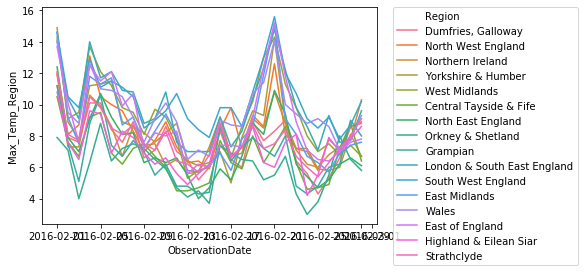

In [25]:
####
#### Plot
####
pandas_df = Region['20160201'].toPandas()
sns.lineplot(x='ObservationDate',y='Max_Temp_Region', data = pandas_df, hue='Region')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.figure(figsize=(30, 15))
plt.show()
#plt.legend(loc='upper left')



In [ ]:
#####
# Section 4 - Scatter Graphs
####

In [26]:
####
###Statistics
####

Numeric = ['bigint','double']

def quick_stat(x):
   for col, coltype in df[x].dtypes:
        if coltype in Numeric:
            df_min = int(df[x].agg({col : 'min'}).collect()[0][0])
            df_max = int(df[x].agg({col : 'max'}).collect()[0][0])
            df_mean = int(df[x].agg({col : 'mean'}).collect()[0][0])
            df_std = int(df[x].agg({col : 'stddev'}).collect()[0][0])
            print(x  + ' ' + col + ":" + " " + "Min:" + str(df_min) + " " + "Mean:" + str(df_mean) + " " + "Max:" + str(df_max) + " " +  "StdDev:" + str(df_std))
            
            
for x in df:
    quick_stat(x)



20160201 ObservationTime: Min:0 Mean:11 Max:23 StdDev:6
20160201 WindDirection: Min:0 Mean:9 Max:16 StdDev:4
20160201 WindSpeed: Min:-99 Mean:9 Max:105 StdDev:21
20160201 Visibility: Min:20 Mean:26029 Max:75000 StdDev:14635
20160201 ScreenTemperature: Min:-9 Mean:4 Max:15 StdDev:3
20160201 Pressure: Min:961 Mean:1006 Max:1036 StdDev:14
20160201 SignificantWeatherCode: Min:0 Mean:6 Max:28 StdDev:3
20160301 ObservationTime: Min:0 Mean:11 Max:23 StdDev:6
20160301 WindDirection: Min:0 Mean:8 Max:16 StdDev:4
20160301 WindSpeed: Min:-99 Mean:6 Max:84 StdDev:21
20160301 Visibility: Min:20 Mean:23776 Max:75000 StdDev:15375
20160301 ScreenTemperature: Min:-8 Mean:5 Max:15 StdDev:3
20160301 Pressure: Min:966 Mean:1013 Max:1040 StdDev:14
20160301 SignificantWeatherCode: Min:0 Mean:6 Max:29 StdDev:3


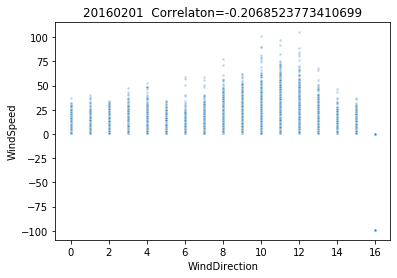

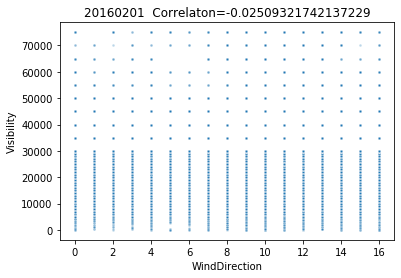

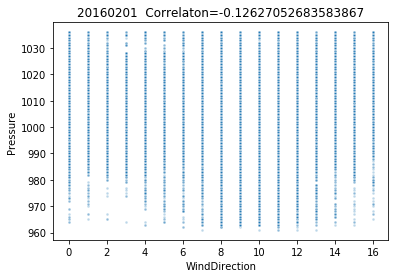

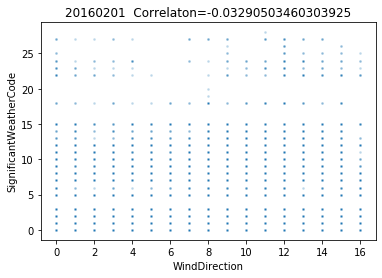

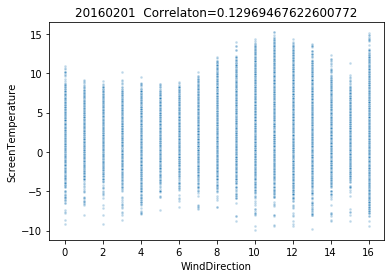

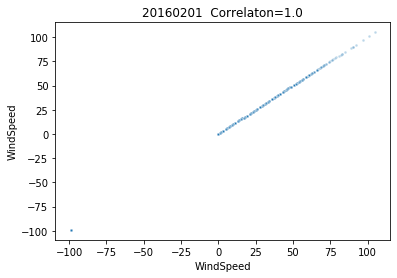

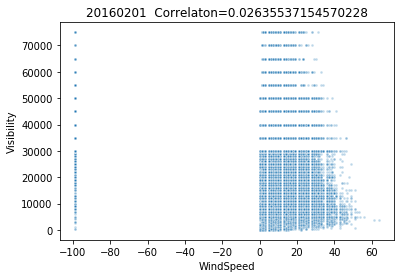

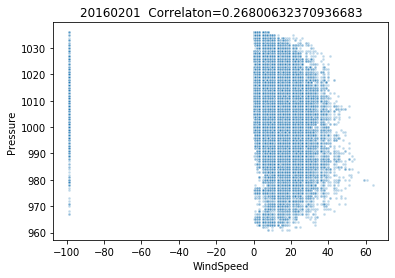

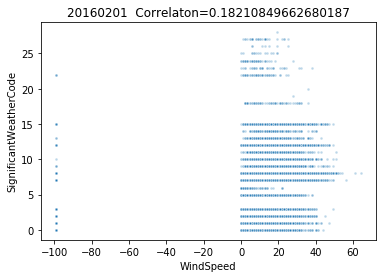

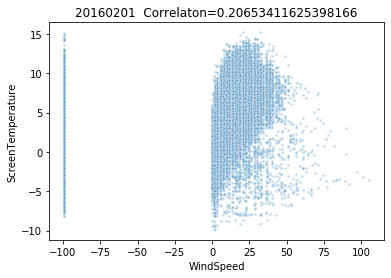

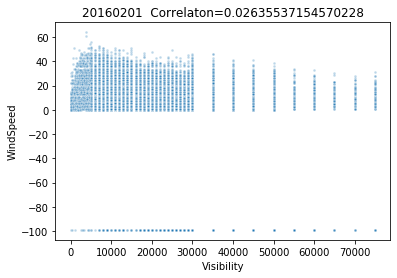

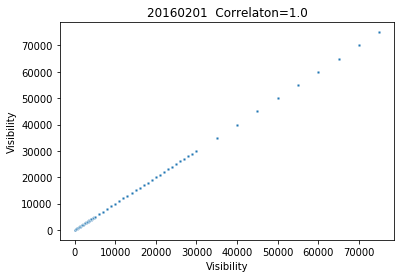

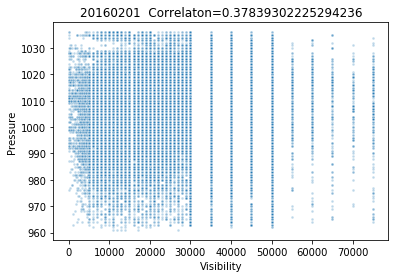

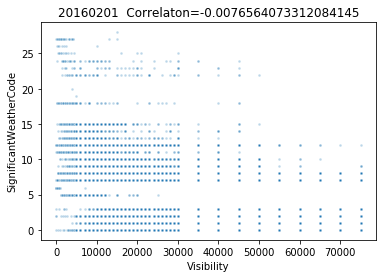

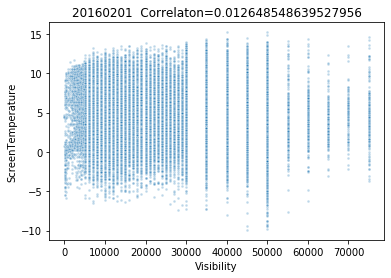

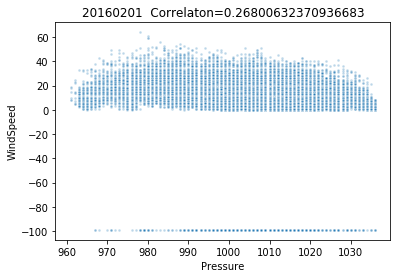

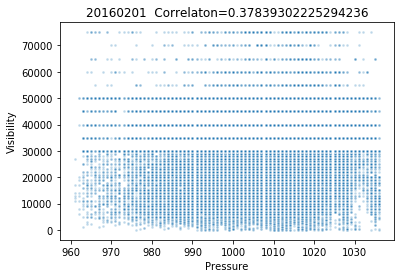

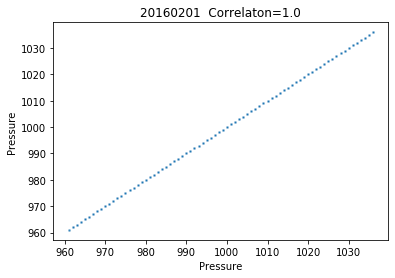

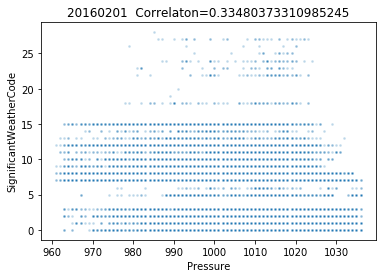

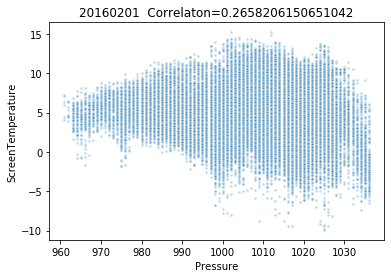

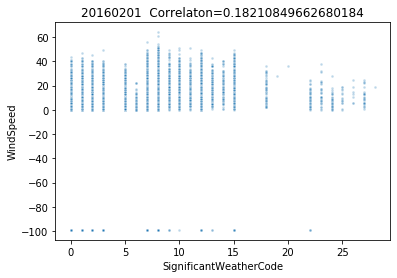

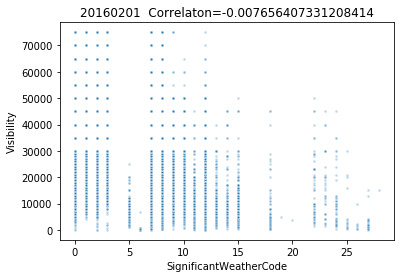

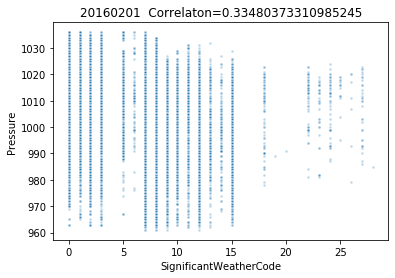

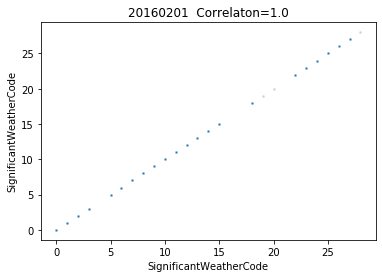

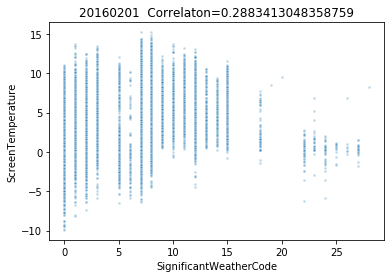

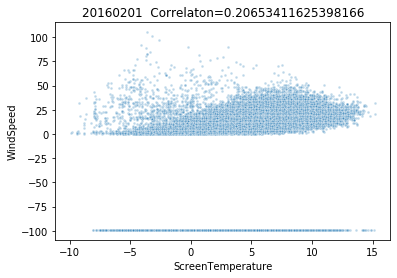

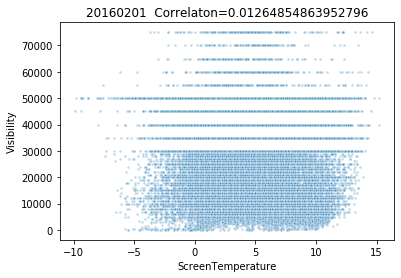

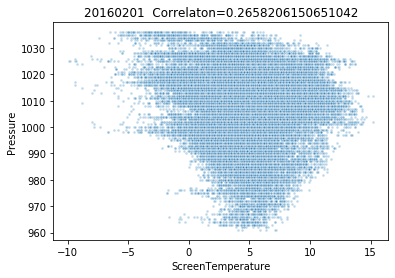

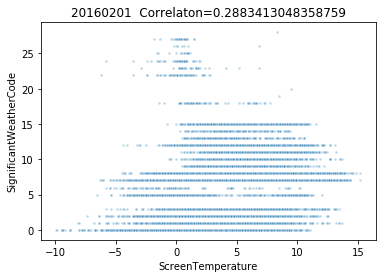

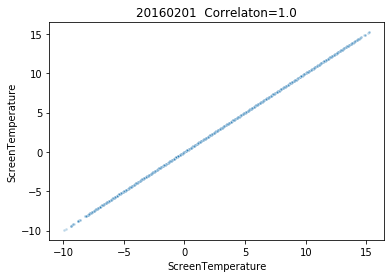

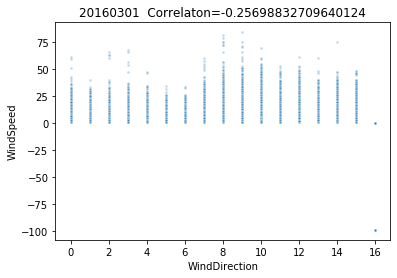

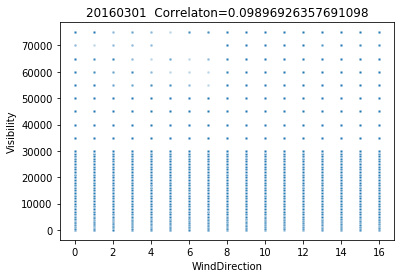

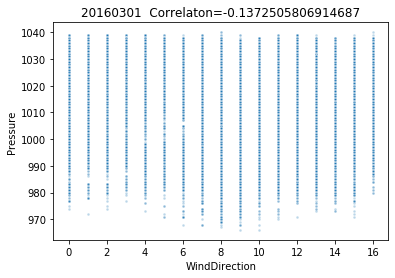

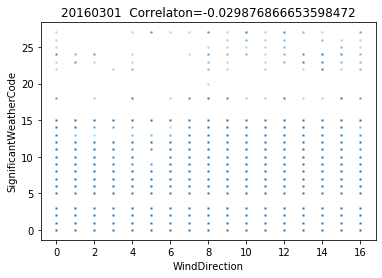

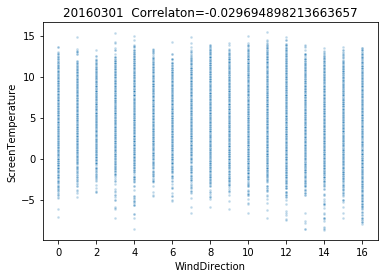

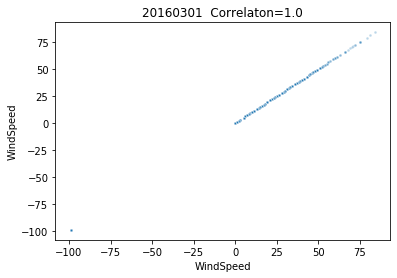

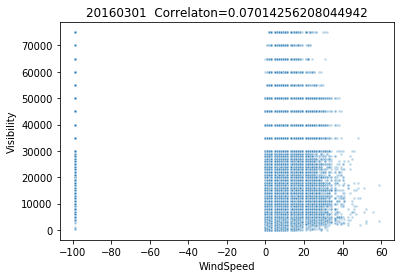

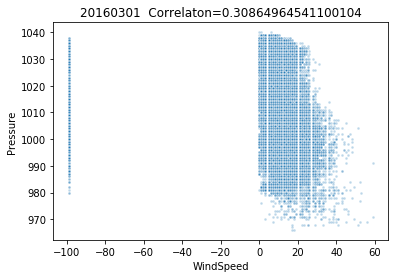

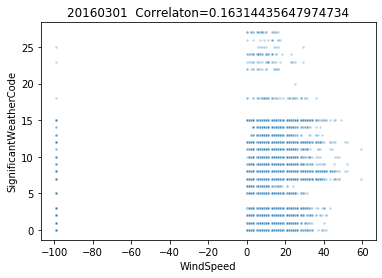

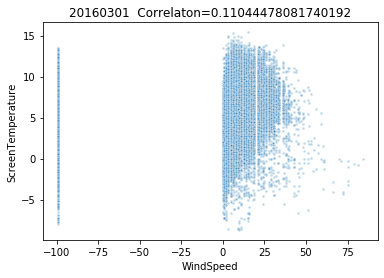

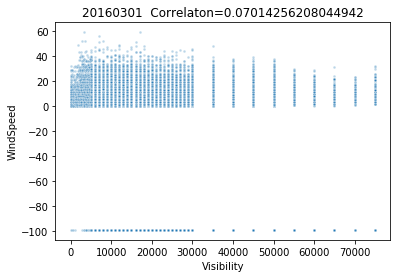

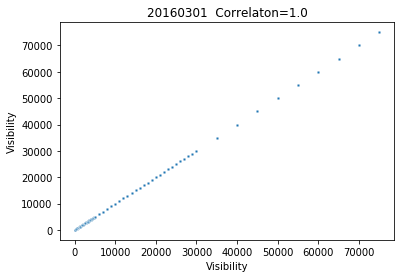

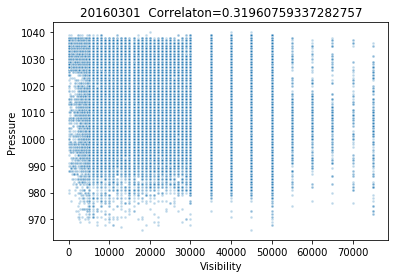

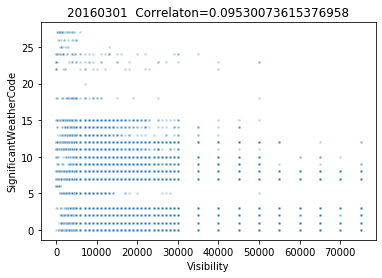

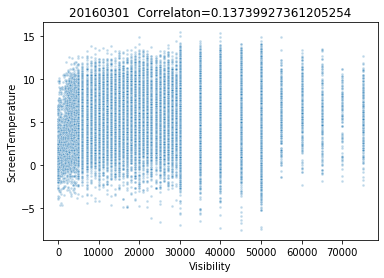

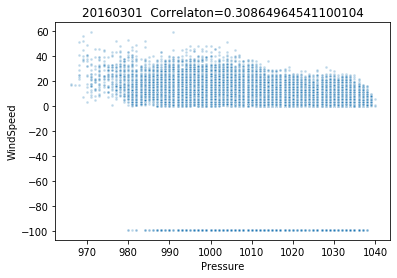

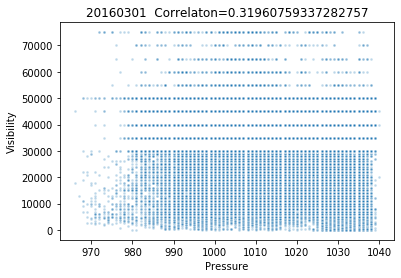

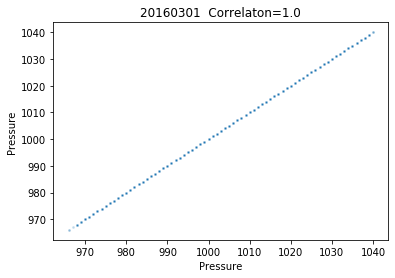

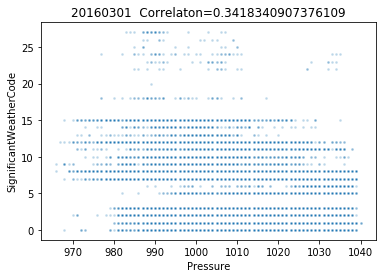

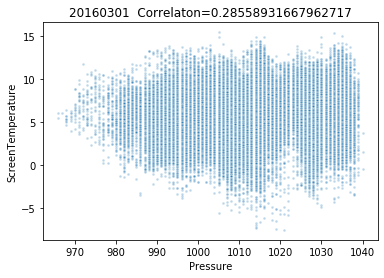

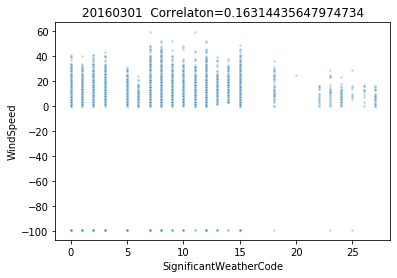

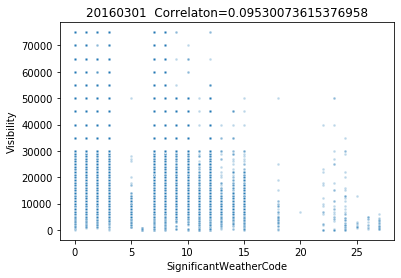

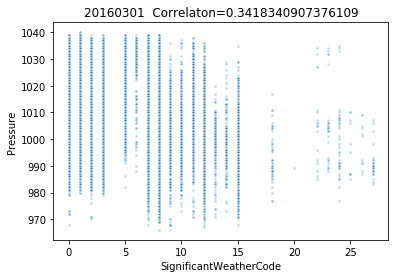

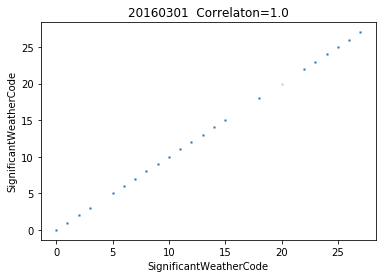

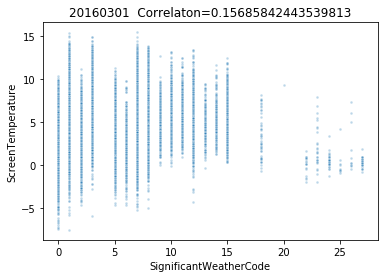

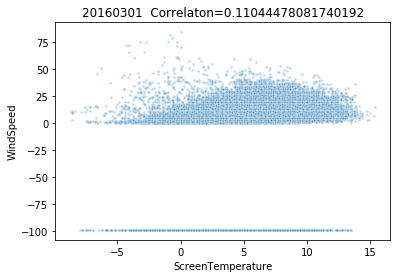

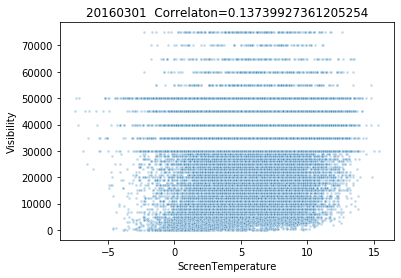

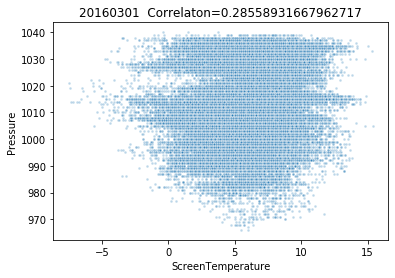

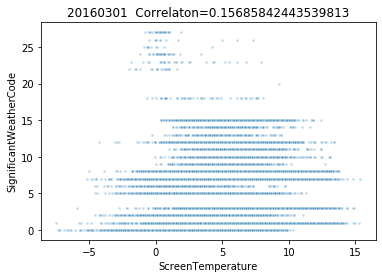

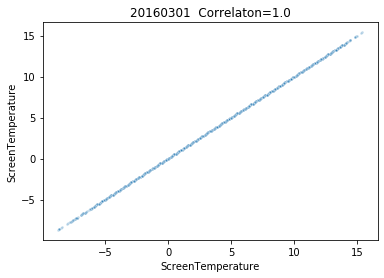

In [27]:
#####
#Generate Scatter Graphs
#### 

Independent_Var = ['WindDirection','WindSpeed','Visibility','Pressure','SignificantWeatherCode','ScreenTemperature']

for x in df:
    sample_df = df[x].select(Independent_Var).sample(False,0.5,42)
    pandas_df = sample_df.toPandas()
    for pos in Independent_Var:
        for pos2 in Independent_Var[1:]:
            correlation = df[x].corr(pos,pos2)
            sns.scatterplot(x=pos, y=pos2, data=pandas_df, s=7, alpha = 0.3).set_title('{}  Correlaton={}'.format(x, correlation))
            plt.show()
            
